In [1]:
from jenkspy import JenksNaturalBreaks
import pandas as pd
import numpy as np
import time
import os
import pickle
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, recall_score, roc_curve, auc
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import PredefinedSplit
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import tensorflow as tf
import shap
from tensorflow.keras import layers
from skopt import BayesSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

import modules.feature_selection as fs
import modules.helper_functions as hf

### Get Data

In [2]:
X, y, X_train, y_train, X_validate, y_validate, X_test, y_test = hf.generateDataFromFile()

generate from files
=== all data loaded from files ===


# Modeling

The modeling phase is normally applied in many iterations. This is done using standard model parameters and tune them afterwards. This can also lead to a return to the data preparation phase because CRISP-DM is a cyclic process. (IBM corporation, 2021; Wirth & Hipp, 2000)

## Selecting Modeling Technique
According to IBM corporation (2021) this sub-process contains the following tasks:
Choosing the Right Modeling Techniques means to answer the following questions: 
* Does the model require to split the data into test and training sets? 
* Is the data sufficient to produce reliable results? 
* Does the model require a certain level of data quality? 
* Are data conversions necessary?
* Are there any data assumptions?

Most of the data work already has been done in the previous data preparation step:
* all continuous data is scaled between 0 and 1 (especially necessary for linear models and Neural Networks in order to converge)
* missing data during feature engineering has already been imputed
* categorical data has been transformed by One-Hot Encoding to dummy variables, this means all data in ```X_train```, ```X_valid``` and ```X_test``` is already in a numerical format which assume most of the modeling algorithms as input data.
* The final training data has 19,243 observations and 53 features. This means the number of predictors is much lower than the number of samples, which implies that also linear modeling techniques like multiple linear regression, logistic regression, and linear discriminant analysis can be used for the problem at hand (Kuhn & Johnson, 2019).
* For models that assume that there is no extreme multicollinearity present in the data, meaning that the between-predictor correlation is not too high (Kuhn & Johnson, 2013), like linear or logistic regression, a correlation-based filter method has already been implemented and is available in the module ```feature_selection.py```. This method was proposed by Kuhn & Johnson (2013, p. 47).

In this case we have a binary outcome variable coded as ```success``` (1) or ```no success```(0). This means the problem at hand is a binary classification problem.

## Generating a Test Design 

According to IBM corporation (2021) and Wirth and Hill (2000) the following tasks have to be defined in this part:
* Describing the criteria for "goodness" of a model 
* Defining the data on which these criteria will be tested

### Writing a Test Design 

According to IBM corporation (2021) the task list for this part is:
* What data will be used to test the models? Have you partitioned the data into train/test sets? 
* How to measure the success of a model?

Unfortunately it is not possible to directly compare the rule based approach of the company and the developed machine learning approach directly, because it is not possible to fully reproduce the current approach. This is why we cannot directly measure, if the machine learning approach also increases the success rate on real data and in a production environment. Hence, it is necessary to formulate acceptable test criteria based on assumptions. Furthermore it is proposed to test both approaches independently for a sufficient transition phase after the machine learning approach is ready to be used in an productive environment.

Assuming that the provided data set are predictions from the company´s current manual and rule-based routing logic the overall success rate can be interpreted as the precision score of the current routing logic. The intuition behind this is, that the current approach identifies for each transaction a positive prediction for the chosen payment service provider. Success for a single transaction would in this context imply a true positive prediction (TP), no success would imply a false positive prediction (FP), if following the described assumption path. The precision score is calculated as follows:

$Precision = \frac{TP}{TP + FP}$

This means that the precision score for the current routing logic would be:

In [3]:
y.mean()

success    0.371758
dtype: float64

If we further assume that the PSP Simplecard is treated as a fall-back option by the current routing logic and would be treated as a negative prediction, the precision would be:

In [4]:
y[X['PSP_Simplecard'] != 1].mean()

success    0.416793
dtype: float64

This means the first baseline-metric to beat by the ML workflow should be a better Precision than 0.42 as the final ML model on hold-out test data. A second baseline-metric to beat would be the accuracy of a majority-vote prediction (in this case for the whole dataset), which would be 1-0.37 = 0.63. This basic baseline-procedure is also proposed by Kuhn & Johnson (2013). Because both described approaches are also considered as heuristics (Todd et al., 1999) the described baseline approach is also in line with the heuristic benchmark design pattern (Lakshmanan et al., 2020). Those metrics are considered as minimum benchmarks for the model in order to proove the 'goodness' of the model.

Baseline models are considered as a first starting point in the modeling process. In general baseline models are simple models that are used as a first reference in a project (Starbuck & Schwab, 2013). According to Nair (2022) the benefits of the usage of baseline models are the usage as performance benchmarks and the improvement of data understanding. As already described in the business understanding part it is essential to develop a model that is good in predicting the success probability for a transaction. Because rule-based heuristics only have probabilities of 0 or 1 a heuristic, rule-based model would not be a suitable baseline in the context of this use case. This is because the first step in this case study is to generate a probability prediction.

Therefore a simple machine learning model that is easy to understand will be developed first. Linear models are a well established baseline in many domains (e.g. Müller & Rauh, 2022). For this case study a logistic regression model with a ```l1``` penalty (also known as Lasso) will be used as a baseline model first. This model has the advantage that the ```l1``` regularization also selects features. This will be the starting point for the further modeling process.

The provided dataset is already split into training, validation and test data. The final model performance is tested on the hold out test data. Validation data is used for hyperparameter tuning and model selection. As already explained a time based splitting strategy has been used to seperate the dataset into training, validation and test data.

A model is considered as ```good```, if it is able to outperform the defined benchmarks above. Furthermore the model needs to seperate the two classes (success or no success) as good as possible. Therefore the area under the receiver operating characteristic curve (ROC AUC) is used as a model selection criteria. The ROC AUC is especially useful when comparing the performance of two models based on their probability predictions (Brownlee, 2021). A model is selected over another model, if the ROC AUC on validation data is higher. 

## Building the Models 

According to IBM corporation the following substeps should be considered in this phase:

### Parameter Settings 
Most modeling techniques have a variety of parameters or settings that can be adjusted to control the modeling process. For example, decision trees can be controlled by adjusting tree depth, splits, and a number of other settings. Typically, most people build a model first using the default options and then refine parameters during subsequent sessions. 

Once you have determined the parameters that produce the most accurate results, be sure to save the stream and generated model nodes. Also, taking notes on the optimal settings can help when you decide to automate or rebuild the model with new data. 

### Running the Models 

In IBM SPSS Modeler, running models is a straightforward task. Once you've inserted the model node into the stream and edited any parameters, simply execute the model to produce viewable results. Results appear in the Generated Models navigator on the right side of the workspace. You can right-click a model to browse the results. For most models, you can insert the generated model into the stream to further evaluate and deploy the results. Models can be also be saved in IBM SPSS Modeler for easy reuse. 

### Model description 

When examining the results of a model, be sure to take notes on your modeling experience. You can store notes with the model itself using the node annotations dialog box or the project tool. Task list For each model, record information such as:
* Can you draw meaningful conclusions from this model?
* Are there new insights or unusual patterns revealed by the model?
* Were there execution problems for the model? How reasonable was the processing time?
* Did the model have difficulties with data quality issues, such as a high number of missing values?
* Were there any calculation inconsistencies that should be noted?

### Building a baseline model

As discussed earlier a logistic regression model with ```l1``` penalty will be fit to the data. The optimal C parameter is found using cross-validation on the validation dataset. The used scoring function to evaluate the best parameters is ROC AUC.

In order to get a better understanding of the performance of the classifier also accuracy and precision are considered as scoring functions.

In [5]:
def generateCV(X_train, y_train, X_validate, y_validate):
    X = pd.concat([X_train, X_validate])
    y = pd.concat([y_train, y_validate]).values.ravel()

    train_indices = list(range(len(X_train)))
    test_indices = list(range(len(X_train), len(X)))

    cv = [(train_indices, test_indices)]
    assert len(cv[0][1]) == len(y_validate), f"Error for validation cv; number expected: {len(y_validate)}, got: {len(cv[0][1])}"
    assert len(cv[0][0]) == len(y_train), f"Error for training cv; number expected: {len(y_train)}, got: {len(cv[0][0])}"
    
    return (X, y, cv)

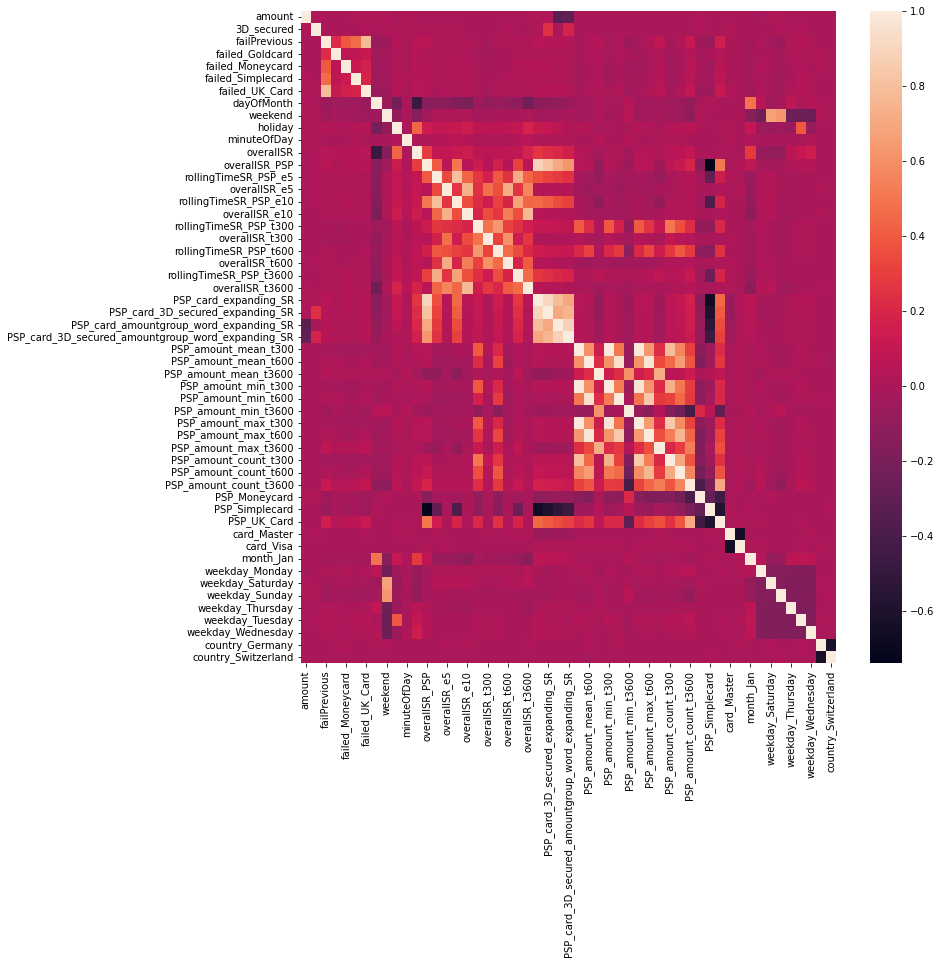

In [6]:
correlated_features = fs.correlationFiltering(X_train, threshold = 0.75, figsize = 12)
selected_features = list(set(X_train.columns) - set(correlated_features))

In [7]:
def createBaseline(X_train, y_train, X_validate, y_validate, selected_features, metrics = ["roc_auc"]):
    X, y, cv = generateCV(X_train, y_train, X_validate, y_validate)
    X = X[selected_features]
    
    models = {}
    for metric in metrics:
        classifier = LogisticRegressionCV(cv=cv, solver="liblinear", 
                                          n_jobs=1, penalty="l1", 
                                          scoring=metric, 
                                          verbose=0, random_state=1977).fit(X, y)
        
        print("=== Best " + metric + " ===")
        print(np.max(classifier.scores_[1]))
        print("=== C parameter for best model ===")
        print(classifier.Cs_[np.argmax(classifier.scores_[1])])
        models[metric] = {'classifier': classifier}
    
    return models

In [8]:
models = createBaseline(X_train, y_train, X_validate, y_validate, selected_features, metrics=["roc_auc"])

=== Best roc_auc ===
0.6985216932997612
=== C parameter for best model ===
0.3593813663804626


In [9]:
def validate_classifier(classifier, X_validate, y_validate, selected_features = list(X_train.columns)):
    if str(type(classifier)) == "<class 'keras.engine.sequential.Sequential'>":
        prob_predictions = [x[0] for x in list(dnn.predict(X_validate))]
    else:
        prob_predictions = classifier.predict_proba(X_validate[selected_features])[:, 1]
    
    if str(type(classifier)) == "<class 'keras.engine.sequential.Sequential'>":
        class_predictions = [x[0] for x in list(np.where(dnn.predict(X_validate) >= 0.5, 1, 0))]
    else:
        class_predictions = classifier.predict(X_validate[selected_features])
    
    print("=== Validation ROC AUC ===")
    print(roc_auc_score(y_validate, prob_predictions))
    print("=== Validation Precision ===")
    print(precision_score(y_validate, class_predictions))
    print("=== Validation Recall ===")
    print(recall_score(y_validate, class_predictions))
    print("=== Validation Accuracy ===")
    print(accuracy_score(y_validate, class_predictions))

In [10]:
validate_classifier(models['roc_auc']['classifier'], X_validate, y_validate, selected_features)

=== Validation ROC AUC ===
0.703825048472568
=== Validation Precision ===
0.5948051948051948
=== Validation Recall ===
0.3173943173943174
=== Validation Accuracy ===
0.6854995150339476


### Model Experiments

A simple baseline model has already been developed. The model is simplistic in terms of the decision boundary, but the model is already tuned in terms of the regularization parameter C. The performance on validation data of the baseline model already outperforms the stated minimum criteria in terms of output performance. Even though the recall score for the model is very low, which means that the baseline model only identifies around 30 % of all successful transactions correctly.

To identify the most promising modeling approach, different approaches will be tested with standard parameter settings as a next step and compared based on ROC AUC on validation data with the baseline model. After this the most promising approach will be tuned to achieve a best possible performance.

#### Tree based ensembles
##### Random Forest

In [11]:
rf_clf_basic = RandomForestClassifier(random_state=1977)
rf_clf = RandomForestClassifier(random_state=1977).fit(X_train, y_train.values.ravel())
validate_classifier(rf_clf, X_validate, y_validate)

=== Validation ROC AUC ===
0.7276279808916885
=== Validation Precision ===
0.6174757281553398
=== Validation Recall ===
0.4407484407484408
=== Validation Accuracy ===
0.7087778855480117


An untuned Random Forest classifier is able to outperform the baseline model in all provided metrics, but most important in terms of ROC AUC.

##### Gradient boosting machine (GBM)

In [12]:
gbm_clf_basic = GradientBoostingClassifier(random_state=1977)
gbm_clf = GradientBoostingClassifier(random_state=1977).fit(X_train, y_train.values.ravel())
validate_classifier(gbm_clf, X_validate, y_validate)

=== Validation ROC AUC ===
0.7344036717404863
=== Validation Precision ===
0.5925
=== Validation Recall ===
0.49272349272349275
=== Validation Accuracy ===
0.7039282250242483


An untuned GBM classifier outperforms the baseline and a random forest classifier.

##### XGBoost

The xgb library has in it´s original version n_estimators set to 10, which is the number of boosting rounds. Therefore this parameter will also be set to 10 in order to achieve a basic comparability between the different models.

In [13]:
xgb_clf_basic = xgb.XGBClassifier(n_estimators=10, random_state=1977)
xgb_clf = xgb.XGBClassifier(n_estimators=10, random_state=1977).fit(X_train, y_train)
validate_classifier(xgb_clf, X_validate, y_validate)

=== Validation ROC AUC ===
0.744526496484721
=== Validation Precision ===
0.6225868725868726
=== Validation Recall ===
0.446985446985447
=== Validation Accuracy ===
0.7116876818622696


The XGBoost classifier outperforms all other tree based models in it´s default settings.

#### Support Vector Machines

In [14]:
svm_lin = SVC(kernel='linear', probability=True, gamma='auto', random_state=1977).fit(X_train, y_train.values.ravel())
validate_classifier(svm_lin, X_validate, y_validate)

=== Validation ROC AUC ===
0.6956762805326774
=== Validation Precision ===
0.6238805970149254
=== Validation Recall ===
0.14483714483714483
=== Validation Accuracy ===
0.6702230843840931


In [15]:
svm_rbf = SVC(kernel='rbf', probability=True, gamma='auto', random_state=1977).fit(X_train, y_train.values.ravel())
validate_classifier(svm_rbf, X_validate, y_validate)

=== Validation ROC AUC ===
0.6892725508913499
=== Validation Precision ===
0.6289855072463768
=== Validation Recall ===
0.15038115038115038
=== Validation Accuracy ===
0.6716779825412221


In [16]:
svm_poly_3 = SVC(kernel='poly', probability=True, gamma='auto', random_state=1977).fit(X_train, y_train.values.ravel())
validate_classifier(svm_poly_3, X_validate, y_validate)

=== Validation ROC AUC ===
0.6765792131327379
=== Validation Precision ===
1.0
=== Validation Recall ===
0.001386001386001386
=== Validation Accuracy ===
0.6505819592628516


All SVM models are performing worse than the baseline model. Nontheless the baseline model was already tuned on the regularization parameter C, which wasn´t done in this example. The SVM models are also very slow in terms of training time. For those reasons, SVM models will not be further evaluated and tuned.

#### Deep Neural Networks (DNN)

This is the last model class in order to preselect the best model to further tune. For the data at hand a classic DNN structure is best suited. A basic DNN structure will be set to: 
* Test

According to Brownlee (2016) this is considered as a good starting point when developint an DNN architecture, even though there is no single golden rule about the starting architecture of a DNN (Heaton, 2022).

In [17]:
def to_tf_ds(X, y):
    out_X = X.copy()
    out_y = y.copy()
    
    target = out_y.pop('success')
    out_X = tf.convert_to_tensor(out_X)
    
    return (out_X, target)

In [18]:
X_train_ds, y_train_ds = to_tf_ds(X_train, y_train)
X_validate_ds, y_validate_ds = to_tf_ds(X_validate, y_validate)
X_test_ds, y_test_ds = to_tf_ds(X_test, y_test)

In [19]:
def get_basic_dnn(input_features = len(X_train.columns)):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(input_features, input_shape=(input_features,), activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=[tf.keras.metrics.AUC()])
    
    return model

In [20]:
dnn = get_basic_dnn()

In [21]:
dnn.fit(X_train_ds, y_train_ds, epochs=50, batch_size=128, validation_data=(X_validate_ds, y_validate_ds))

Epoch 1/50
151/151 [==============================] - 1s 4ms/step - loss: 0.6384 - auc: 0.6332 - val_loss: 0.6176 - val_auc: 0.6658
Epoch 2/50
151/151 [==============================] - 0s 2ms/step - loss: 0.6194 - auc: 0.6748 - val_loss: 0.6056 - val_auc: 0.6894
Epoch 3/50
151/151 [==============================] - 0s 2ms/step - loss: 0.6142 - auc: 0.6847 - val_loss: 0.5999 - val_auc: 0.6951
Epoch 4/50
151/151 [==============================] - 0s 2ms/step - loss: 0.6115 - auc: 0.6888 - val_loss: 0.5954 - val_auc: 0.6999
Epoch 5/50
151/151 [==============================] - 0s 2ms/step - loss: 0.6093 - auc: 0.6931 - val_loss: 0.5962 - val_auc: 0.7002
Epoch 6/50
151/151 [==============================] - 0s 2ms/step - loss: 0.6070 - auc: 0.6965 - val_loss: 0.6068 - val_auc: 0.7014
Epoch 7/50
151/151 [==============================] - 0s 2ms/step - loss: 0.6051 - auc: 0.6997 - val_loss: 0.5924 - val_auc: 0.7030
Epoch 8/50
151/151 [==============================] - 0s 2ms/step - loss: 0.

In [22]:
validate_classifier(dnn, X_validate, y_validate)

129/129 [==============================] - 0s 1ms/step
=== Validation ROC AUC ===
0.6897944339197604
=== Validation Precision ===
0.5904317386231038
=== Validation Recall ===
0.35065835065835066
=== Validation Accuracy ===
0.6876818622696411


The described DNN model has a similar performance than the baseline model but gets outperformed by the tree-based ensemble approaches.

**Conclusion**: The tree based ensemble methods came to the most promising modeling results. Therefore this model family will be used for hyperparameter optimization. The final decision on the model to choose will be based on the performance of the tuned model on test data.

### Feature Selection
Overall the tree based ensemble models like random forest, XGBoost and Gradient Boosting Machines outperform the oter models in their basic settings. A next step would be to further tune those models and select the best performing model in terms of performance on test data. A first step in the tuning process is to select the best suited features for each model. This is done in a two step approach. According to Kuhn and Johnson (2019) a correlation based feature selection is recommended for tree based models before moving to a model based selection process. As a next step a model centric feature selection is applied. This is done using Recursive Feature Elimination, which is the most widely used approach (Kuhn & Johnson, 2019).

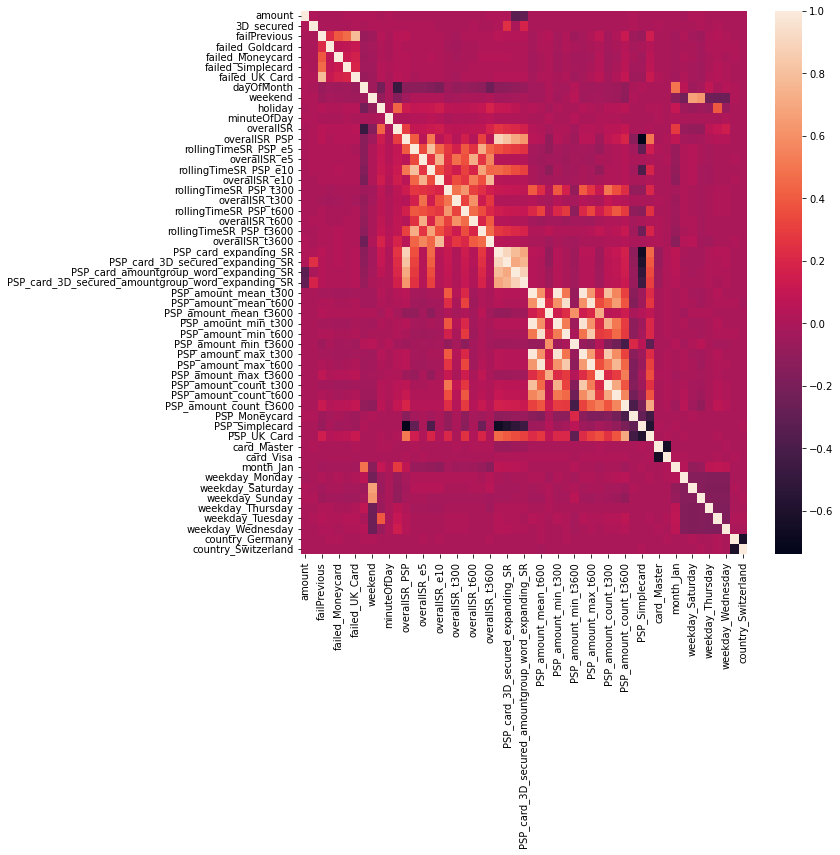

=== Highly correlated variables to drop ===
['PSP_amount_max_t300', 'PSP_amount_mean_t300', 'failPrevious', 'overallSR_PSP', 'PSP_card_3D_secured_expanding_SR', 'PSP_card_expanding_SR', 'PSP_amount_max_t600', 'overallSR_e10', 'PSP_card_amountgroup_word_expanding_SR', 'rollingTimeSR_PSP_e10', 'PSP_amount_mean_t600']
=== Columns after removal ===
['amount', '3D_secured', 'failed_Goldcard', 'failed_Moneycard', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'weekend', 'holiday', 'minuteOfDay', 'overallSR', 'rollingTimeSR_PSP_e5', 'overallSR_e5', 'rollingTimeSR_PSP_t300', 'overallSR_t300', 'rollingTimeSR_PSP_t600', 'overallSR_t600', 'rollingTimeSR_PSP_t3600', 'overallSR_t3600', 'PSP_card_3D_secured_amountgroup_word_expanding_SR', 'PSP_amount_mean_t3600', 'PSP_amount_min_t300', 'PSP_amount_min_t600', 'PSP_amount_min_t3600', 'PSP_amount_max_t3600', 'PSP_amount_count_t300', 'PSP_amount_count_t600', 'PSP_amount_count_t3600', 'PSP_Moneycard', 'PSP_Simplecard', 'PSP_UK_Card', 'card_Master',

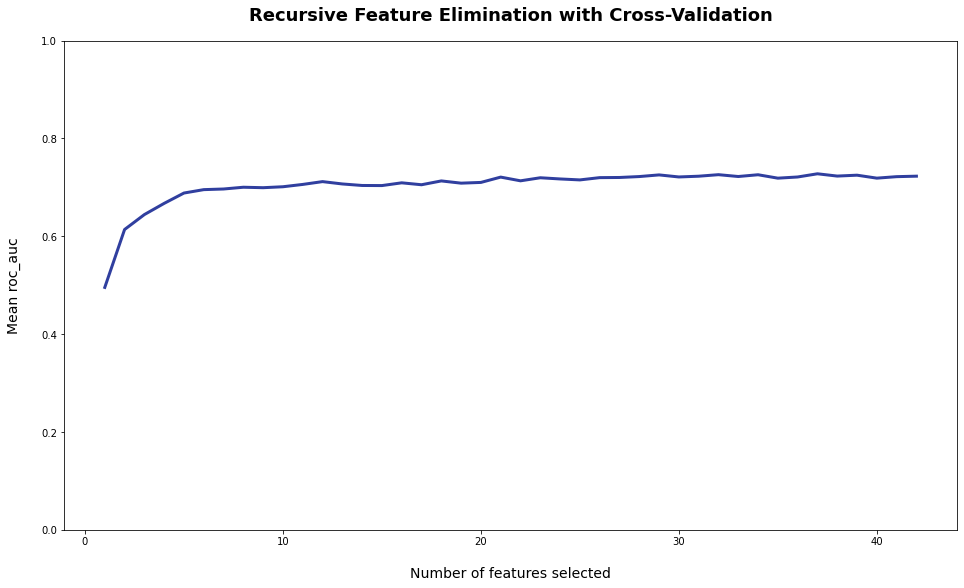

= Features:
['amount', '3D_secured', 'failed_Moneycard', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'weekend', 'minuteOfDay', 'overallSR', 'rollingTimeSR_PSP_e5', 'overallSR_e5', 'overallSR_t300', 'rollingTimeSR_PSP_t600', 'overallSR_t600', 'rollingTimeSR_PSP_t3600', 'overallSR_t3600', 'PSP_card_3D_secured_amountgroup_word_expanding_SR', 'PSP_amount_mean_t3600', 'PSP_amount_min_t300', 'PSP_amount_min_t600', 'PSP_amount_min_t3600', 'PSP_amount_max_t3600', 'PSP_amount_count_t300', 'PSP_amount_count_t600', 'PSP_amount_count_t3600', 'PSP_Moneycard', 'PSP_Simplecard', 'PSP_UK_Card', 'card_Master', 'card_Visa', 'month_Jan', 'weekday_Monday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'country_Germany', 'country_Switzerland']
= Maximum Test Score:
0.7276760592687486
=== Most important features ===
{'roc_auc': ['amount', '3D_secured', 'failed_Moneycard', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'weekend', 'minuteOfDay', 'overallSR', 'rollingTimeSR_PSP_e5'

In [23]:
features_rf = fs.applyFeatureSelection(
    X_train, y_train, X_validate, y_validate, X_test, y_test,
    metrics = ["roc_auc"],
    estimator = rf_clf_basic,
    correlation_threshold = 0.75,
    step = 1,
    figsize = 10,
    write_model = False
)

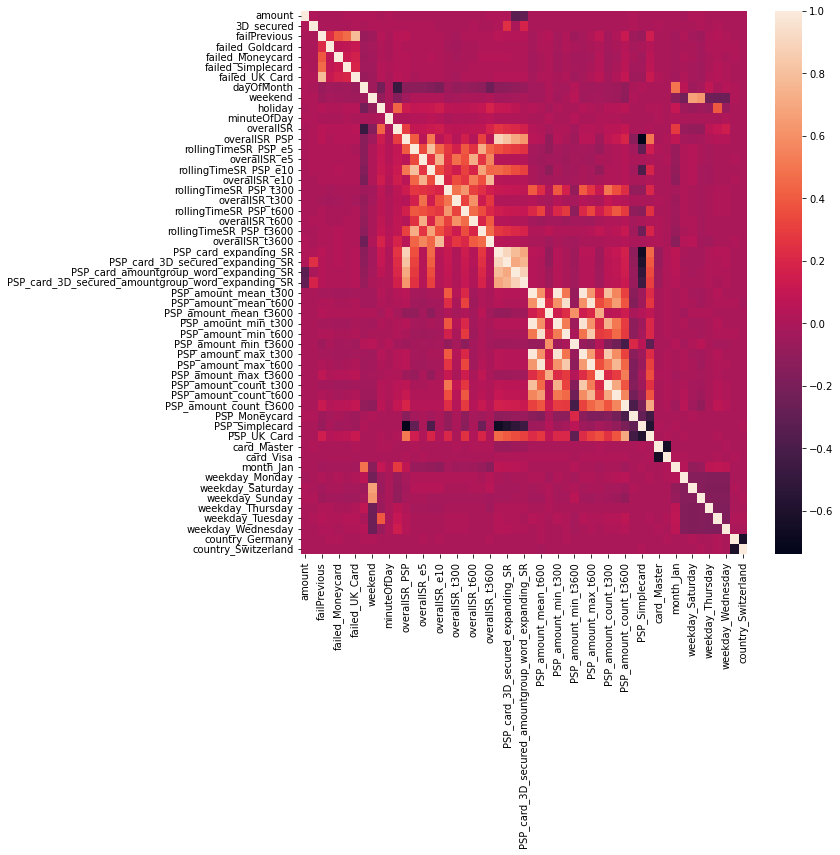

=== Highly correlated variables to drop ===
['PSP_amount_max_t300', 'PSP_amount_mean_t300', 'failPrevious', 'overallSR_PSP', 'PSP_card_3D_secured_expanding_SR', 'PSP_card_expanding_SR', 'PSP_amount_max_t600', 'overallSR_e10', 'PSP_card_amountgroup_word_expanding_SR', 'rollingTimeSR_PSP_e10', 'PSP_amount_mean_t600']
=== Columns after removal ===
['amount', '3D_secured', 'failed_Goldcard', 'failed_Moneycard', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'weekend', 'holiday', 'minuteOfDay', 'overallSR', 'rollingTimeSR_PSP_e5', 'overallSR_e5', 'rollingTimeSR_PSP_t300', 'overallSR_t300', 'rollingTimeSR_PSP_t600', 'overallSR_t600', 'rollingTimeSR_PSP_t3600', 'overallSR_t3600', 'PSP_card_3D_secured_amountgroup_word_expanding_SR', 'PSP_amount_mean_t3600', 'PSP_amount_min_t300', 'PSP_amount_min_t600', 'PSP_amount_min_t3600', 'PSP_amount_max_t3600', 'PSP_amount_count_t300', 'PSP_amount_count_t600', 'PSP_amount_count_t3600', 'PSP_Moneycard', 'PSP_Simplecard', 'PSP_UK_Card', 'card_Master',

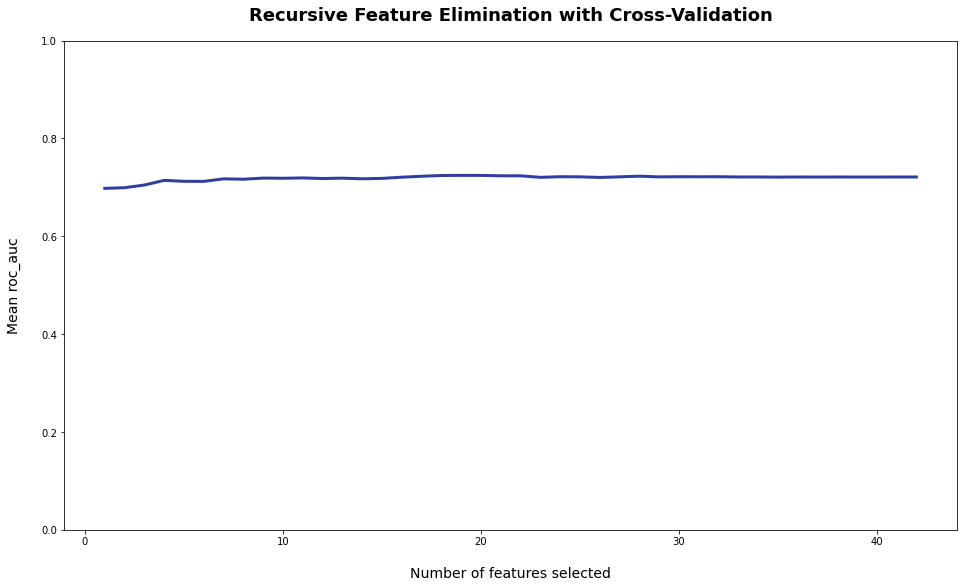

= Features:
['amount', '3D_secured', 'failed_UK_Card', 'dayOfMonth', 'minuteOfDay', 'overallSR', 'rollingTimeSR_PSP_e5', 'rollingTimeSR_PSP_t3600', 'overallSR_t3600', 'PSP_card_3D_secured_amountgroup_word_expanding_SR', 'PSP_amount_mean_t3600', 'PSP_amount_min_t300', 'PSP_amount_min_t600', 'PSP_amount_min_t3600', 'PSP_amount_max_t3600', 'PSP_amount_count_t3600', 'PSP_Moneycard', 'PSP_UK_Card', 'card_Master']
= Maximum Test Score:
0.7244390403659333
=== Most important features ===
{'roc_auc': ['amount', '3D_secured', 'failed_UK_Card', 'dayOfMonth', 'minuteOfDay', 'overallSR', 'rollingTimeSR_PSP_e5', 'rollingTimeSR_PSP_t3600', 'overallSR_t3600', 'PSP_card_3D_secured_amountgroup_word_expanding_SR', 'PSP_amount_mean_t3600', 'PSP_amount_min_t300', 'PSP_amount_min_t600', 'PSP_amount_min_t3600', 'PSP_amount_max_t3600', 'PSP_amount_count_t3600', 'PSP_Moneycard', 'PSP_UK_Card', 'card_Master']}


In [24]:
features_gbm = fs.applyFeatureSelection(
    X_train, y_train, X_validate, y_validate, X_test, y_test,
    metrics = ["roc_auc"],
    estimator = gbm_clf_basic,
    correlation_threshold = 0.75,
    step = 1,
    figsize = 10,
    write_model = False
)

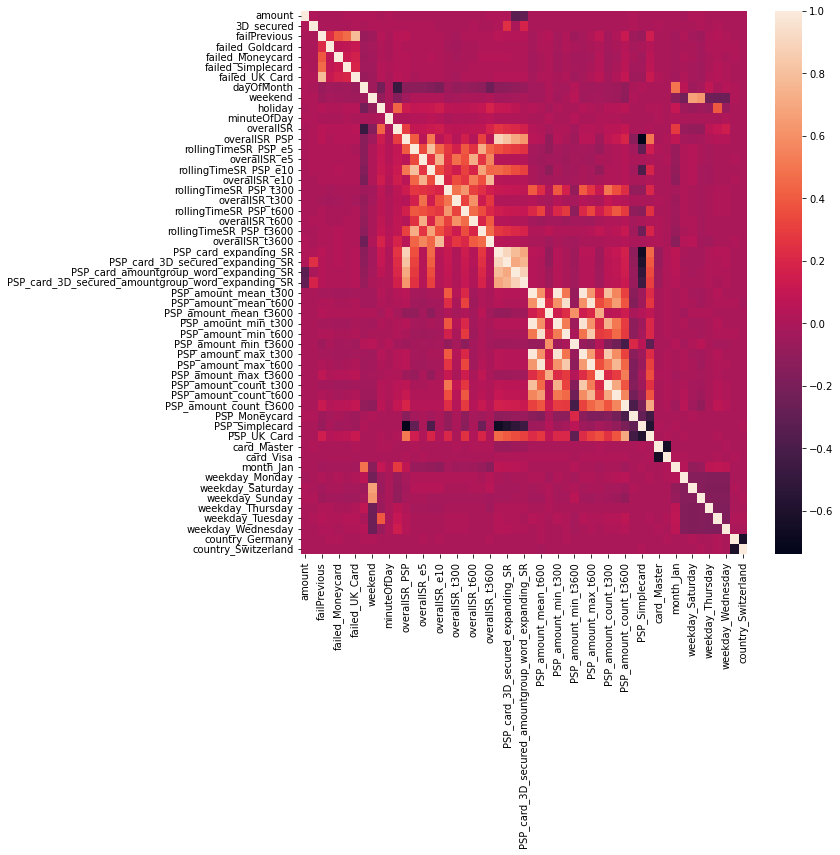

=== Highly correlated variables to drop ===
['PSP_amount_max_t300', 'PSP_amount_mean_t300', 'failPrevious', 'overallSR_PSP', 'PSP_card_3D_secured_expanding_SR', 'PSP_card_expanding_SR', 'PSP_amount_max_t600', 'overallSR_e10', 'PSP_card_amountgroup_word_expanding_SR', 'rollingTimeSR_PSP_e10', 'PSP_amount_mean_t600']
=== Columns after removal ===
['amount', '3D_secured', 'failed_Goldcard', 'failed_Moneycard', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'weekend', 'holiday', 'minuteOfDay', 'overallSR', 'rollingTimeSR_PSP_e5', 'overallSR_e5', 'rollingTimeSR_PSP_t300', 'overallSR_t300', 'rollingTimeSR_PSP_t600', 'overallSR_t600', 'rollingTimeSR_PSP_t3600', 'overallSR_t3600', 'PSP_card_3D_secured_amountgroup_word_expanding_SR', 'PSP_amount_mean_t3600', 'PSP_amount_min_t300', 'PSP_amount_min_t600', 'PSP_amount_min_t3600', 'PSP_amount_max_t3600', 'PSP_amount_count_t300', 'PSP_amount_count_t600', 'PSP_amount_count_t3600', 'PSP_Moneycard', 'PSP_Simplecard', 'PSP_UK_Card', 'card_Master',

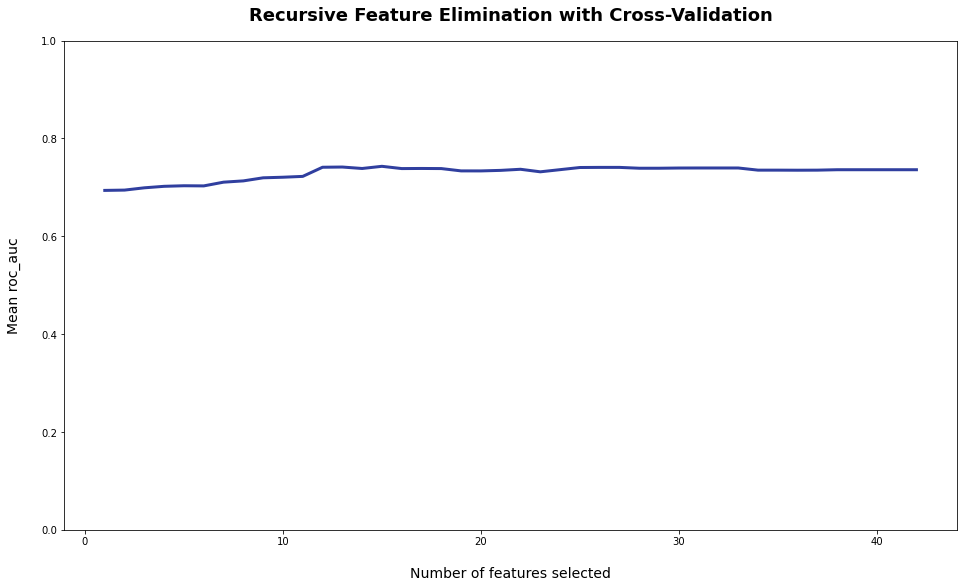

= Features:
['amount', '3D_secured', 'failed_Moneycard', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'minuteOfDay', 'overallSR', 'rollingTimeSR_PSP_t3600', 'PSP_card_3D_secured_amountgroup_word_expanding_SR', 'PSP_Moneycard', 'PSP_Simplecard', 'PSP_UK_Card', 'card_Master', 'card_Visa']
= Maximum Test Score:
0.7429633030155225
=== Most important features ===
{'roc_auc': ['amount', '3D_secured', 'failed_Moneycard', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'minuteOfDay', 'overallSR', 'rollingTimeSR_PSP_t3600', 'PSP_card_3D_secured_amountgroup_word_expanding_SR', 'PSP_Moneycard', 'PSP_Simplecard', 'PSP_UK_Card', 'card_Master', 'card_Visa']}


In [25]:
features_xgb = fs.applyFeatureSelection(
    X_train, y_train, X_validate, y_validate, X_test, y_test,
    metrics = ["roc_auc"],
    estimator = xgb_clf_basic,
    correlation_threshold = 0.75,
    step = 1,
    figsize = 10,
    write_model = False
)

**Conclusion**: The feature selection process and the achieved performance score on validation data clearly show, that the XGBoost classifier outperforms the other tree ensembles. XGBoost comes to the most sparse model and achieves the best ROC AUC score. Therefore only XGBoost will be considered for hyperparameter optimization.

### Hyperparameter Optimization

#### XGBoost

In [26]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from sklearn.model_selection import cross_val_score

X_tune, y_tune, cv_tune = generateCV(X_train, y_train, X_validate, y_validate)
X_tune = X_tune[features_xgb['roc_auc']]
X_train_hyper = X_train[features_xgb['roc_auc']]
X_validate_hyper = X_validate[features_xgb['roc_auc']]
X_test_hyper = X_test[features_xgb['roc_auc']]

space = [
    Integer(3, 18, name = 'max_depth'),
    Real(1, 9, name = 'gamma'),
    Integer(0, 100, name = 'reg_alpha'),
    Integer(0, 100, name = 'reg_lambda'),
    Integer(0, 10, name = 'min_child_weight'),
    Integer(5, 1000, name = 'n_estimators'),
    Real(0.001, 0.3, name = 'learning_rate'),
    Real(0.5, 1, name = 'subsample'),
    Real(0.4, 1, name = 'colsample_bytree'),
    Real(0.4, 1, name = 'colsample_bylevel')
]

def objective(params):
    model = xgb.XGBClassifier(
        max_depth = params[0],
        gamma = params[1],
        reg_alpha = params[2],
        reg_lambda = params[3],
        min_child_weight = params[4],
        n_estimators = params[5],
        learning_rate = params[6],
        subsample = params[7],
        colsample_bytree = params[8],
        colsample_bylevel = params[9],
        n_jobs = -1
    )
    
    score = cross_val_score(model, X_tune, y_tune, cv = cv_tune, n_jobs = -1, scoring = 'roc_auc').mean()
    
    return -score

result = gp_minimize(objective, space, n_calls=50, random_state = 1977, verbose = 1)

xgb_clf_tuned = xgb.XGBClassifier(
        max_depth = result.x[0],
        gamma = result.x[1],
        reg_alpha = result.x[2],
        reg_lambda = result.x[3],
        min_child_weight = result.x[4],
        n_estimators = result.x[5],
        learning_rate = result.x[6],
        subsample = result.x[7],
        colsample_bytree = result.x[8],
        colsample_bylevel = result.x[9],
        eval_metric="auc",
        early_stopping_rounds=10,
        n_jobs = -1,
        random_state = 1977
    ).fit(X_train_hyper, y_train, eval_set=[(X_validate_hyper, y_validate)])

X_train_val = pd.concat([X_train_hyper, X_validate_hyper])
y_train_val = pd.concat([y_train, y_validate]).values.ravel()

xgb_clf_final = xgb.XGBClassifier(
        max_depth = result.x[0],
        gamma = result.x[1],
        reg_alpha = result.x[2],
        reg_lambda = result.x[3],
        min_child_weight = result.x[4],
        n_estimators = result.x[5],
        learning_rate = result.x[6],
        subsample = result.x[7],
        colsample_bytree = result.x[8],
        colsample_bylevel = result.x[9],
        n_jobs = -1,
        random_state = 1977
    ).fit(X_train_val, y_train_val)

print("======================================")
# print(f"Best score: {-result.fun}")
print("Best hyperparameters: ", dict(zip(['max_depth', 'gamma', 
                                          'reg_alpha', 'reg_lambda', 'min_child_weight', 
                                          'n_estimators', 'learning_rate', 'subsample', 
                                          'colsample_bytree'], result.x)))
print("= Validation results for tuned classifier:")
validate_classifier(xgb_clf_tuned, X_validate_hyper, y_validate, selected_features = features_xgb['roc_auc'])
print("======================================")

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.5021
Function value obtained: -0.6992
Current minimum: -0.6992
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.0037
Function value obtained: -0.7018
Current minimum: -0.7018
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.4463
Function value obtained: -0.7345
Current minimum: -0.7345
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.4875
Function value obtained: -0.7065
Current minimum: -0.7345
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.3076
Function value obtained: -0.7272
Current minimum: -0.7345
Iteration No: 6 started. 

Hyperparametertuning and Feature selection increased the performance on validation data of the model and reduced the complexity considerably by reducing the number of used features from 53 to just 15, which also increases the interpretability of the prediction results, which will be addressed in the next step.

**Conclusion**: The added value of hyperparameter tuning is not very high if sticking to good heuristic hyperparameter approaches in the model exploration phase. The final model decision will be done based on the model performance on test data.

In [27]:
print("=== Final result for XGB trained on training and validation data and evaluated on test data ===")
validate_classifier(xgb_clf_final, X_test_hyper, y_test, selected_features = features_xgb['roc_auc'])

=== Final result for XGB trained on training and validation data and evaluated on test data ===
=== Validation ROC AUC ===
0.7592273251003347
=== Validation Precision ===
0.6286995515695067
=== Validation Recall ===
0.48245010323468684
=== Validation Accuracy ===
0.7171962163473199


In [28]:
fs.writePickle(path = "./models/xgb_clf_final.pkl", object = xgb_clf_final)
fs.writePickle(path = "./models/xgb_clf_final_features.pkl", object = features_xgb['roc_auc'])

Whereas the validation dataset was used by the model for optimization and cross validation the test dataset has never been seen by the model yet. By applying the final model on test data it is possible to assess how well the model really does on unseen future data and if the model overfits.

As we can see from the validation results on test data, it can be concluded that the model has very similar results on test data than on validation data. Hence, the model does not overfit the data and achieves much better results than the baseline model.

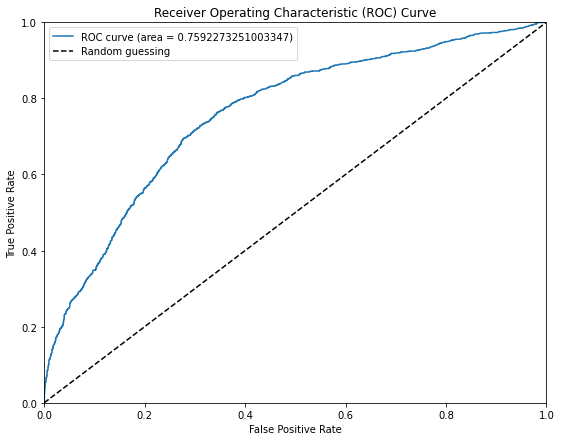

In [29]:
y_probabilities = xgb_clf_final.predict_proba(X_test[features_xgb['roc_auc']])[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 7))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc})")
plt.plot([0, 1], [0, 1], 'k--', label="Random guessing")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

## Assessing the Model
### Calibrate the classifier

Tree based models are only able to predict probability-like scores and does therefore not produce probabilities by default. Therefore the scores of the XGBoost classifier have to be calibrated, such that they can be interpreted as probabilities. This is essential because the complete intuition of the defined approach for this case study is based on probabilities. The first step is to visualize how far off the model scores are from a perfectly calibrated classifier. This is done by a so called calibration curve.

In [30]:
xgb_probabilities = list(xgb_clf_tuned.predict_proba(X_validate_hyper)[:, 1])
xgb_y, xgb_x = calibration_curve(y_validate, xgb_probabilities, n_bins = 10)

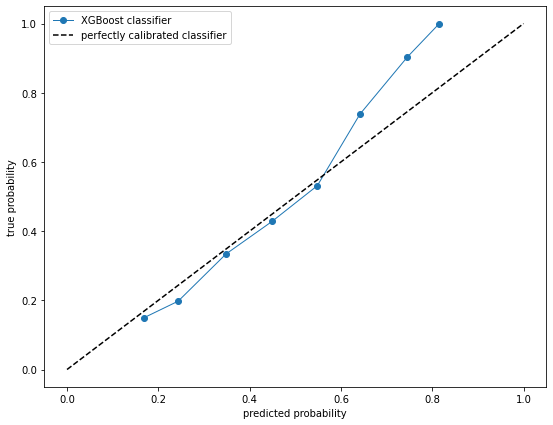

In [31]:
plt.figure(figsize=(9, 7))
plt.plot(xgb_x, xgb_y, marker = 'o', linewidth = 1, label = 'XGBoost classifier')
plt.plot([0, 1], [0, 1], 'k--', label = 'perfectly calibrated classifier')
plt.xlabel('predicted probability')
plt.ylabel('true probability')
plt.legend()
plt.show()

From the plot it can be concluded, that the trained classifier underestimates the true probability for predicted scores greater than 0.55 and works as expected for scores lower than that. The underestimation for the higher scores is linear, therefore it is not necessarily indicated to calibrate the classifier. The final decision will be made by comparing the calibrated model with the final XGBoost classifier. Therefore the next step is to calibrate the classifier in order to make the predicted scores match the true likelihood. The two main techniques are Platt scaling and isotonic regression. Whereas Platt scaling relies on a sigmoid logistic regression model, isotonic regression fits a non-parametric isotonic regressor on the data. In general the isotonic approach will perform as well as or better than the Platt approach, given enough data (Niculescu-Mizil & Caruana, 2005). Hence an isotonic regression is used to calibrate the XGBoost classifier.

In [32]:
xgb_final_classifier = xgb.XGBClassifier(
        max_depth = result.x[0],
        gamma = result.x[1],
        reg_alpha = result.x[2],
        reg_lambda = result.x[3],
        min_child_weight = result.x[4],
        n_estimators = result.x[5],
        learning_rate = result.x[6],
        subsample = result.x[7],
        colsample_bytree = result.x[8],
        colsample_bylevel = result.x[9],
        n_jobs = -1,
        random_state = 1977
    )

calibrated_xgb_clf = CalibratedClassifierCV(xgb_final_classifier, cv=cv_tune).fit(X_tune, y_tune)

In [33]:
validate_classifier(calibrated_xgb_clf, X_validate, y_validate, selected_features = features_xgb['roc_auc'])

=== Validation ROC AUC ===
0.7438213469545062
=== Validation Precision ===
0.5944487278334618
=== Validation Recall ===
0.5343035343035343
=== Validation Accuracy ===
0.7095053346265762


In [34]:
validate_classifier(xgb_clf_final, X_validate, y_validate, selected_features = features_xgb['roc_auc'])

=== Validation ROC AUC ===
0.7582203039122098
=== Validation Precision ===
0.6197301854974705
=== Validation Recall ===
0.5093555093555093
=== Validation Accuracy ===
0.7189621726479146


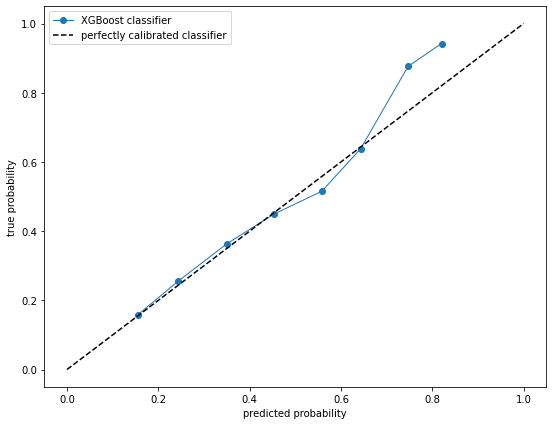

In [35]:
xgb_probabilities = list(calibrated_xgb_clf.predict_proba(X_validate_hyper)[:, 1])
xgb_y, xgb_x = calibration_curve(y_validate, xgb_probabilities, n_bins = 10)

plt.figure(figsize=(9, 7))
plt.plot(xgb_x, xgb_y, marker = 'o', linewidth = 1, label = 'XGBoost classifier')
plt.plot([0, 1], [0, 1], 'k--', label = 'perfectly calibrated classifier')
plt.xlabel('predicted probability')
plt.ylabel('true probability')
plt.legend()
plt.show()

**Conclusion**: Overall the model calibration decreases the performance of the classifier and is also not able to completely remove the underestimation of the true probability for high predicted scores. Hence, the final XGBoost classifier trained after hyperparameter tuning will be retained.

### Model explanation

In [36]:
explainer = shap.TreeExplainer(xgb_clf_final,  model_output="probability", feature_perturbation='interventional', data=X_test_hyper)
shap_values = explainer.shap_values(X_test_hyper)

#### Explanations for single predictions

In [37]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test_hyper.iloc[2,:])

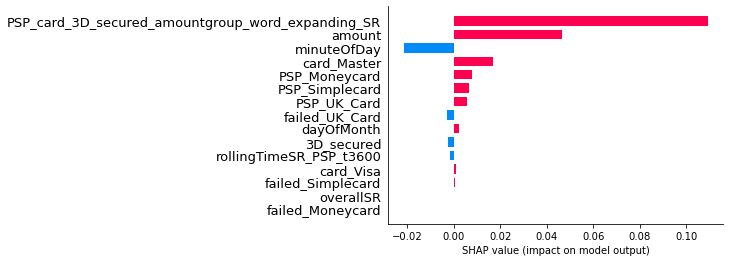

In [38]:
shap.bar_plot(shap_values[2, :], feature_names=X_test_hyper.columns, max_display=15)

In [39]:
explainer.expected_value

0.3670529174254822

In [51]:
np.mean(np.abs(shap_values), axis = 0)

array([0.0341856 , 0.01117922, 0.00127464, 0.00125417, 0.00786433,
       0.00093727, 0.01944551, 0.00013476, 0.00648897, 0.10271545,
       0.01048452, 0.01471068, 0.01866022, 0.01298069, 0.00228755])

In [53]:
X_test_hyper.columns

Index(['amount', '3D_secured', 'failed_Moneycard', 'failed_Simplecard',
       'failed_UK_Card', 'dayOfMonth', 'minuteOfDay', 'overallSR',
       'rollingTimeSR_PSP_t3600',
       'PSP_card_3D_secured_amountgroup_word_expanding_SR', 'PSP_Moneycard',
       'PSP_Simplecard', 'PSP_UK_Card', 'card_Master', 'card_Visa'],
      dtype='object')

#### Overall feature contributions

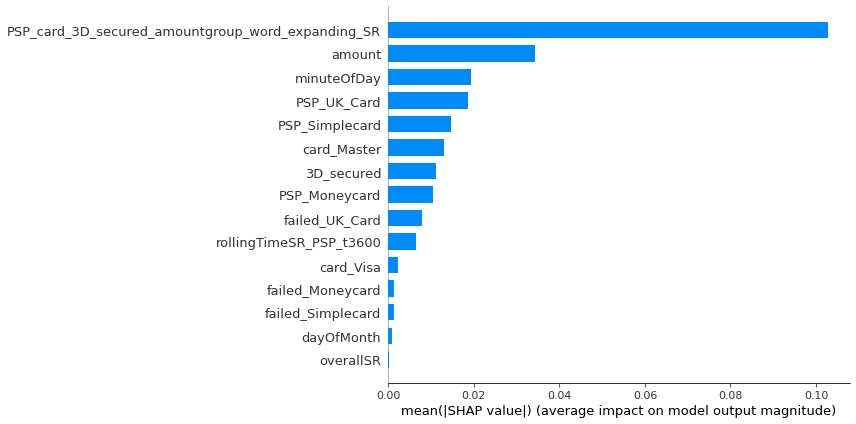

In [41]:
shap.summary_plot(shap_values, X_test_hyper, plot_type="bar", plot_size = (12, 6))

## References

<p>Arlot, S., & Celisse, A. (2010). A survey of cross-validation procedures for model selection. Statistics Surveys, 4(none). https://doi.org/10.1214/09-SS054</p>
<p>Athanasopoulos, G., & Hyndman, R. J. (2021). Forecasting: Principles and Practice (3. Aufl.). OTexts. OTexts.com/fpp3</p>
<p>Bygari, R., Gupta, A., Raghuvanshi, S., Bapna, A., & Sahu, B. (2021). An AI-powered Smart Routing Solution for Payment Systems. 2026–2033. https://doi.org/10.1109/BigData52589.2021.9671961</p>
<p>Chetcuti, J. (2020). PhiCor: Calculating Phi coefficient of Association. (edsbas.C61D16BC). BASE. https://doi.org/10.5281/zenodo.3898308
IBM Corporation. (2021). IBM Documentation: IBM SPSS Modeler CRISP-DM Guide. https://www.ibm.com/docs/en/spss-modeler/18.1.1?topic=spss-modeler-crisp-dm-guide</p>
<p>Kornbrot, D. (2005). Point Biserial Correlation. https://doi.org/10.1002/0470013192.bsa485</p>
<p>Kuhn, M., & Johnson, K. (2013). Applied Predictive Modeling (1st ed. 2013, Corr. 2nd printing 2018 Edition). Springer.</p>
<p>Kuhn, M., & Johnson, K. (2019). Feature Engineering and Selection: A Practical Approach for Predictive Models. Taylor & Francis Ltd. http://www.feat.engineering/</p>
<p>Lakshmanan, V., Robinson, S., & Munn, M. (2020). Machine Learning Design Patterns: Solutions to Common Challenges in Data Preparation, Model Building, and MLOps. O’Reilly Media.</p>
<p>Leonard, M., & Wolfe, B. (2005). Mining transactional and time series data. abstract, presentation and paper, SUGI, 10–13.</p>
<p>Mao, X., Xu, S., Kumar, R., R, V., Hong, X., & Menghani, D. (2023). Improving the customer’s experience via ML-driven payment routing. https://engineering.linkedin.com/blog/2023/improving-the-customer-s-experience-via-ml-driven-payment-routin</p>
<p>Mu, L. (2021). Using Machine Learning to Improve Payment Authorization Rate | The PayPal Technology Blog. https://medium.com/paypal-tech/using-machine-learning-to-improve-payment-authorization-rates-bc3b2cbf4999</p>
<p>Wirth, R., & Hipp, J. (2000). CRISP-DM: Towards a standard process model for data mining. Proceedings of the 4th International Conference on the Practical Applications of Knowledge Discovery and Data Mining.</p>